# Roberta experiment
We will try to use transfer learning to get an improvement and also because we will need to train the model for less time, so in that case, we will be choosing Roberta.

RoBERTa (A Robustly Optimized BERT Pretraining Approach) is an advanced natural language processing (NLP) model developed by Facebook AI that builds upon BERT (Bidirectional Encoder Representations from Transformers). It enhances BERT's performance by improving the pretraining process, including training on larger datasets, removing the "next sentence prediction" task, increasing the batch size, and utilizing dynamic masking during training. These optimizations make RoBERTa more robust and better suited for a wide range of NLP tasks, such as sentiment analysis, text classification, and question answering. Despite its similarities to BERT, RoBERTa's architectural tweaks and training improvements allow it to achieve higher accuracy and generalization across diverse language understanding benchmarks.


In this case, we will just go with some predefined values for the training:

- DROPOUT_VALUE = 0.1
- LEARNING_RATE = 2e-5
- WEIGHT_DECAY = 0.01
- WARMUP_RATIO = 0.1
- EPOCHS = 5
- THRESHOLD_PROBABILITIES_MODEL = 0.5
- AdamW as a optimizer

In [ ]:
%%capture
!pip install pytorch_lightning mlflow dagshub wandb

In [ ]:
# Standard Library Imports
import os
import math
from typing import List, Dict

# Third-party Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud
import nltk
import torch
import pytorch_lightning as pl
from sklearn.metrics import accuracy_score, recall_score
import mlflow
import wandb

# PyTorch Libraries
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Hugging Face Transformers
from transformers import (
    BertTokenizer, BertModel, AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
)

# PyTorch Lightning Callbacks and Loggers
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import MLFlowLogger
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import AutoModel, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score
import mlflow
import mlflow.pytorch

# import google drive
from google.colab import drive, files
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

"""Import the modules from google colab"""
import sys
PATH_helper = "/content/drive/MyDrive/turing_college_experiments/16/helper"
sys.path.append(PATH_helper)
# Custom imports
from helper_eda import (proportion_balance_classes, extractions_text_description, histogram_bins,
                                plot_distribution_tokens_per_word, dimensionality_reduction_chart_tsne,
                               components_pca_3d_chart)

"""
Verify the cores and gpu in the colab
"""
num_cores = os.cpu_count()  # Get the number of CPU cores
print(f'Number of available CPU cores: {num_cores}')
NUM_WORKERS = num_cores - 1
print(f'Setting num_workers to: {NUM_WORKERS}')

num_gpus_colab = torch.cuda.device_count()
GPU_LIST = [torch.cuda.get_device_name(i) for i in range(num_gpus_colab)]
NUM_WORKERS, GPU_LIST

enable_code_paths = True
enable_block = False

# weight and biases
wandb.login()

# ml versioning control
import dagshub
import mlflow
import mlflow.sklearn
dagshub.init(repo_owner='auszed', repo_name='Experiments_fake_news', mlflow=True)

# tracking experiments
os.environ['MLFLOW_TRACKING_USERNAME'] = 'auszed'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '4390ce1796189f46f62a5e643463dcaffede3ebf'
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/auszed/Experiments_fake_news.mlflow'


# Download the stopwords if you haven't already
nltk.download('stopwords')

# Inline plotting for Jupyter Notebooks
%matplotlib inline
custom_colors = ['#36CE8A', "#7436F5","#3736F4",   "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
gradient_colors = [ "#36CE8A", '#7436F5']
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)
cmap_theme = LinearSegmentedColormap.from_list('custom_colormap', gradient_colors)

# File paths
X_train = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/X_train_simplify.csv")
y_train = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/y_train.csv")
X_val = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/X_val_simplify.csv")
y_val = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/y_val.csv")
X_test = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/X_test_simplify.csv")
y_test = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/y_test.csv")

X_train = X_train[["title_text_join"]]
X_val = X_val[["title_text_join"]]
X_test = X_test[["title_text_join"]]

print(X_train.shape,y_train.shape )
print(X_val.shape,y_val.shape )
print(X_test.shape,y_test.shape )
theme_color

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Number of available CPU cores: 12
Setting num_workers to: 11


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=aa0ba1c6-bedc-4b0e-b1fa-8a9fd9df2917&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=b0b2f72deccddcff99a93070bf514c494d534444f66caac8f413a29aed8c3674




Accessing as auszed

Initialized MLflow to track repo "auszed/Experiments_fake_news"

Repository auszed/Experiments_fake_news initialized!

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(26759, 1) (26759, 1)
(5734, 1) (5734, 1)
(5735, 1) (5735, 1)


[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

In [ ]:
#@title sample dataset for experiments
# sample size
enable_samples: bool = False #@param
SAMPLE_PERCENTAGE_X_train = 1 #@param
SAMPLE_PERCENTAGE_X_val = 1 #@param
SAMPLE_PERCENTAGE_X_test = 1 #@param

MODEL_NAME = "roberta-base" #@param
VERSION_MODEL = "004" #@param
NAME_EXPERIMENTS = "Fake news comments" #@param
DATASET_NAME = "X_train_simplify" #@param title
OPTIMIZER_NAME = "AdamW" #@param
BATCH_SIZE = 8 #@param
DROPOUT_VALUE = 0.1 #@param
NUM_LABELS = 1 #@param
LEARNING_RATE = 2e-5 #@param
WEIGHT_DECAY = 0.01 #@param
WARMUP_RATIO = 0.1 #@param
EPOCHS = 5 #@param
THRESHOLD_PROBABILITIES_MODEL = 0.5 #@param

URL_SAVE_MODEL = f"/content/drive/MyDrive/turing_college_experiments/16/model_save/{MODEL_NAME}_{VERSION_MODEL}.pth"

if enable_samples:
    X_train = X_train.sample(frac=SAMPLE_PERCENTAGE_X_train,random_state=42)
    X_val = X_val.sample(frac=SAMPLE_PERCENTAGE_X_val,random_state=42)
    X_test = X_test.sample(frac=SAMPLE_PERCENTAGE_X_test,random_state=42)
    y_train = y_train.sample(frac=SAMPLE_PERCENTAGE_X_train,random_state=42)
    y_val = y_val.sample(frac=SAMPLE_PERCENTAGE_X_val,random_state=42)
    y_test = y_test.sample(frac=SAMPLE_PERCENTAGE_X_test,random_state=42)


print("TRAIN Dataset: {}".format(X_train.shape))
print("VALIDATION Dataset: {}".format(X_val.shape))
print("TEST Dataset: {}".format(X_test.shape))
print("TRAIN Dataset y: {}".format(y_train.shape))
print("VALIDATION Dataset y: {}".format(y_val.shape))
print("TEST Dataset y: {}".format(y_test.shape))

sample_data = 5 #@param
X_train.sample(sample_data)

TRAIN Dataset: (26759, 1)
VALIDATION Dataset: (5734, 1)
TEST Dataset: (5735, 1)
TRAIN Dataset y: (26759, 1)
VALIDATION Dataset y: (5734, 1)
TEST Dataset y: (5735, 1)


,title_text_join
14243,"""The people have spoken,"" Zimbabwe's Mnangagwa..."
4837,Danish inventor had murder videos on his compu...
16390,Norwegian policeman jailed for 21 years in dru...
3847,"Iran's quake death toll rises to 530, more tha..."
3762,WHOA! SOROS LINKED GROUP Funding Ohio’s John K...


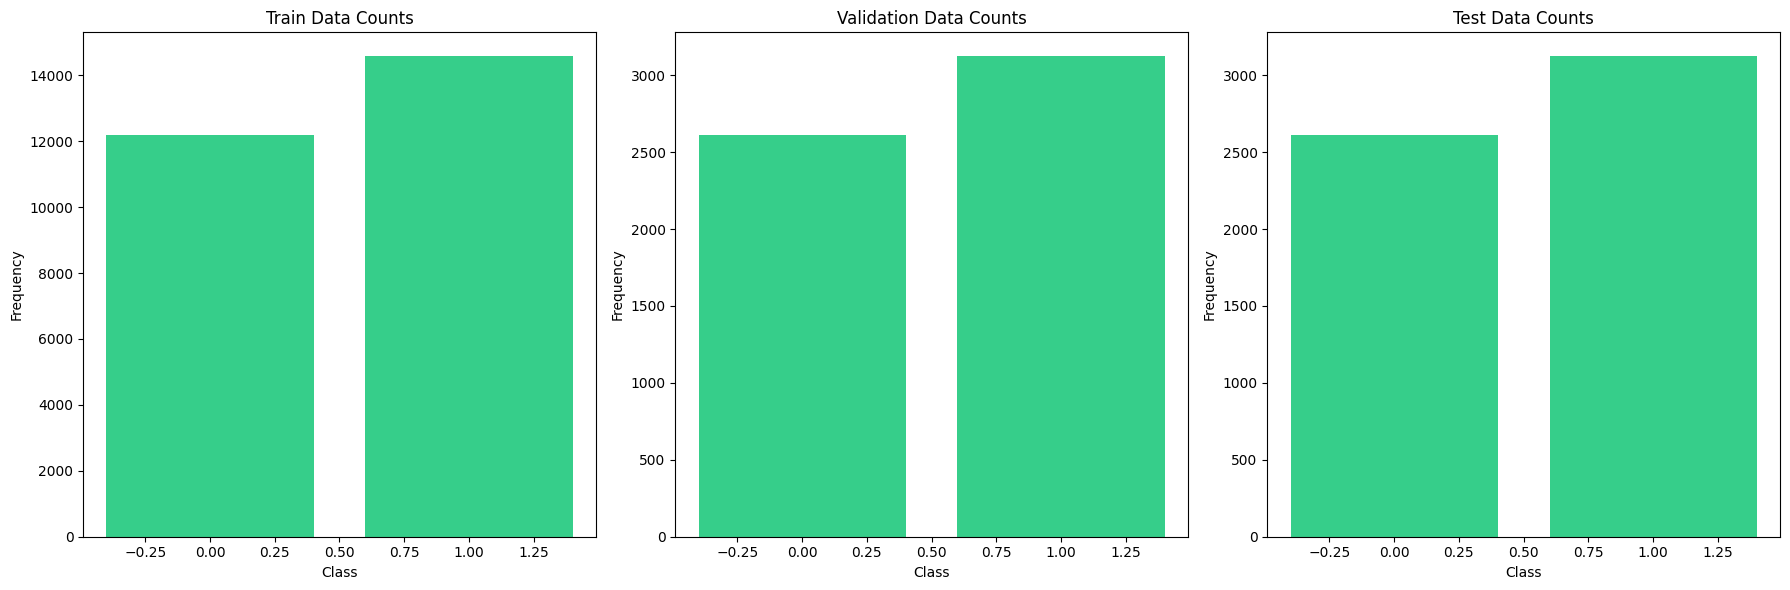

In [ ]:
#@title Split of the dataset
# Get counts for each dataset
train_counts = y_train.value_counts().reset_index()
val_counts = y_val.value_counts().reset_index()
test_counts = y_test.value_counts().reset_index()
train_counts.columns = ['Class', 'Frequency']
val_counts.columns = ['Class', 'Frequency']
test_counts.columns = ['Class', 'Frequency']

real_values = train_counts['Frequency'][0]
fake_values = train_counts['Frequency'][1]
total_values = train_counts['Frequency'].sum()
real_percentage = (real_values / total_values)
fake_percentage = (fake_values / total_values)

normalized_weights = torch.tensor([real_percentage, fake_percentage], dtype=torch.float)
# normalized_weights = torch.tensor([0.5895522388059702, 0.41044776119402987], dtype=torch.float)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot for train data
# Convert index to numerical values
ax[0].bar(train_counts['Class'], train_counts['Frequency'])
ax[0].set_title('Train Data Counts')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')

# Plot for validation data
# Convert index to numerical values
ax[1].bar(val_counts['Class'], val_counts['Frequency'])
ax[1].set_title('Validation Data Counts')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')

# Plot for test data
# Convert index to numerical values
ax[2].bar(test_counts['Class'], test_counts['Frequency'])
ax[2].set_title('Test Data Counts')
ax[2].set_xlabel('Class')
ax[2].set_ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
#@title Dataloader
class CustomDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, comment_str_title: str, tokenizer, target_variable: pd.DataFrame, max_token_len=256):
        assert isinstance(dataframe, pd.DataFrame), "dataframe needs to be a pandas DataFrame for this code to work"
        assert isinstance(target_variable, pd.DataFrame), "target_variable needs to be a pandas DataFrame for this code to work"

        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.target_variable = target_variable
        self.comment_str_title = comment_str_title

    def chunk_text(self, text, max_length, stride):
        tokens = self.tokenizer.encode_plus(
            text,
            add_special_tokens=False,
            max_length=None,
            truncation=False,
            return_attention_mask=False,
            return_token_type_ids=False
        )['input_ids']

        chunks = []
        for i in range(0, len(tokens), stride):
            chunk = tokens[i:i + max_length]
            if len(chunk) < max_length:
                chunk += [self.tokenizer.pad_token_id] * (max_length - len(chunk))  # Padding
            chunks.append(chunk)
        return chunks

    def __len__(self):
        """Length of the dataset"""
        return len(self.dataframe)

    def __getitem__(self, index):
        """Get a single item"""
        data_row = self.dataframe.iloc[index]
        comment = str(data_row[self.comment_str_title])
        data_row_target = torch.tensor(self.target_variable.iloc[index].values, dtype=torch.float)

        # Split the comment into chunks
        chunks = self.chunk_text(comment, max_length=self.max_token_len, stride=self.max_token_len // 2)

        input_ids = []
        attention_masks = []

        for chunk in chunks:
            # Here, `chunk` is already tokenized, so we directly create tensors
            tokens = {
                "input_ids": torch.tensor(chunk, dtype=torch.long),
                "attention_mask": torch.tensor([1 if id != self.tokenizer.pad_token_id else 0 for id in chunk], dtype=torch.long)
            }
            input_ids.append(tokens["input_ids"])
            attention_masks.append(tokens["attention_mask"])

        return {
            "input_ids": torch.stack(input_ids),
            "attention_masks": torch.stack(attention_masks),
            "labels": data_row_target
        }

# Model configuration
model_name = 'roberta-base'
tokenizer_roberta = AutoTokenizer.from_pretrained(model_name)

# dataloaders for training, val, test
dataset_loader_X_train = CustomDataset(
    dataframe=X_train,
    comment_str_title='title_text_join',
    target_variable=y_train,
    tokenizer=tokenizer_roberta,
    max_token_len=256
)
dataset_loader_X_val = CustomDataset(
    dataframe=X_val,
    comment_str_title='title_text_join',
    target_variable=y_train,
    tokenizer=tokenizer_roberta,
    max_token_len=256
)
dataset_loader_X_test = CustomDataset(
    dataframe=X_test,
    comment_str_title='title_text_join',
    target_variable=y_train,
    tokenizer=tokenizer_roberta,
    max_token_len=256
)

# Test the dataset
print("Dataset train length:", len(dataset_loader_X_train))
print("Dataset val length:", len(dataset_loader_X_val))
print("Dataset test length:", len(dataset_loader_X_test))
sample = dataset_loader_X_train[0]
print("Sample input IDs shape:", sample["input_ids"].shape)
print("Sample attention masks shape:", sample["attention_masks"].shape)
print("Sample labels:", sample["labels"])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors


Dataset train length: 26759
Dataset val length: 5734
Dataset test length: 5735
Sample input IDs shape: torch.Size([5, 256])
Sample attention masks shape: torch.Size([5, 256])
Sample labels: tensor([1.])


In [ ]:
# value_review = 22
# print(X_train.iloc[value_review])
# print(y_train.iloc[value_review])
# dataset_loader_X_train.__getitem__(value_review)

In [ ]:
#@title Batches
def custom_collate_fn(batch: List[Dict]) -> Dict:
    """
    Custom collate function to handle variable number of chunks per sample.
    """
    # Get the max number of chunks in this batch
    max_chunks = max(sample["input_ids"].size(0) for sample in batch)

    # Get batch size and sequence length
    batch_size = len(batch)
    seq_length = batch[0]["input_ids"].size(1)

    # Initialize tensors to hold padded data
    padded_input_ids = torch.zeros((batch_size, max_chunks, seq_length), dtype=torch.long)
    padded_attention_masks = torch.zeros((batch_size, max_chunks, seq_length), dtype=torch.long)

    # Collect labels
    labels = torch.stack([sample["labels"] for sample in batch])

    # Create chunk attention mask to identify valid chunks
    chunk_attention_mask = torch.zeros((batch_size, max_chunks), dtype=torch.long)

    # Fill in the tensors with actual data
    for i, sample in enumerate(batch):
        num_chunks = sample["input_ids"].size(0)
        padded_input_ids[i, :num_chunks, :] = sample["input_ids"]
        padded_attention_masks[i, :num_chunks, :] = sample["attention_masks"]
        chunk_attention_mask[i, :num_chunks] = 1

    return {
        "input_ids": padded_input_ids,
        "attention_masks": padded_attention_masks,
        "chunk_attention_mask": chunk_attention_mask,
        "labels": labels
    }


# Create DataLoader with custom collate function
train_loader = DataLoader(
    dataset=dataset_loader_X_train,
    batch_size=BATCH_SIZE,  # Adjust based on your GPU memory
    shuffle=True,
    collate_fn=custom_collate_fn,
    num_workers= NUM_WORKERS,  # Adjust based on your CPU cores
    pin_memory=True,  # Set to True if using GPU
    drop_last=True
)
val_loader = DataLoader(
    dataset=dataset_loader_X_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers= NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)
test_loader = DataLoader(
    dataset=dataset_loader_X_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers= NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)


print(len(train_loader), "train_loader batch")
print(len(val_loader), "val_loader batch")
print(len(test_loader), "test_loader batch")


3344 train_loader batch
716 val_loader batch
716 test_loader batch


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import AutoModel, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, recall_score

class ClassifierModel(nn.Module):
    def __init__(self, config):
        super(ClassifierModel, self).__init__()
        self.config = config

        # Pretrained model
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict=True)

        # Layers
        self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        self.classification = nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])

        # Initialize weights
        nn.init.kaiming_normal_(self.hidden.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.classification.weight, nonlinearity='sigmoid')

        # Loss function
        self.loss_function = nn.BCEWithLogitsLoss()

        # Dropout
        self.dropout = nn.Dropout(config['dropout_vals'])

    def forward(self, input_ids, attention_mask, chunk_attention_mask=None):
        batch_size, num_chunks, seq_length = input_ids.size()
        input_ids = input_ids.view(-1, seq_length)
        attention_mask = attention_mask.view(-1, seq_length)

        # Forward pass through the pretrained model
        output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = torch.mean(output.last_hidden_state, 1)
        pooled_output = pooled_output.view(batch_size, num_chunks, -1)

        if chunk_attention_mask is not None:
            chunk_attention_mask = chunk_attention_mask.float().unsqueeze(-1)
            pooled_output = (pooled_output * chunk_attention_mask).sum(dim=1) / chunk_attention_mask.sum(dim=1).clamp(min=1)
        else:
            pooled_output = pooled_output.mean(dim=1)

        # Classification layers
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.hidden(pooled_output)
        # pooled_output = F.relu(pooled_output)
        logits = self.classification(pooled_output)
        logits = F.sigmoid(logits)

        return logits


print("y_train shape:", y_train.shape)
print("Sample label:", y_train.iloc[0])

config = {
    "model_name": MODEL_NAME,
    "n_labels": NUM_LABELS,
    "lr": LEARNING_RATE,
    "w_decay": WEIGHT_DECAY,
    "dropout_vals": DROPOUT_VALUE,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "train_size": len(dataset_loader_X_train),
    "warmup": WARMUP_RATIO
}


# Reinitialize the model with the updated config
model = ClassifierModel(config)
model.to(device)
model

y_train shape: (26759, 1)
Sample label: target_variable    1
Name: 0, dtype: int64


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ClassifierModel(
  (pretrained_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [ ]:
# Freeze all layers initially
for param in model.pretrained_model.parameters():
    param.requires_grad = False

# Enable only the 10th and 11th layers
for layer_idx in [10, 11]:
    for param in model.pretrained_model.encoder.layer[layer_idx].parameters():
        param.requires_grad = True

# Enable the pooler layer
for param in model.pretrained_model.pooler.parameters():
    param.requires_grad = True

# Verify which layers are trainable
print("Trainable Parameters:")
for name, param in model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

Trainable Parameters:
pretrained_model.embeddings.word_embeddings.weight: Frozen
pretrained_model.embeddings.position_embeddings.weight: Frozen
pretrained_model.embeddings.token_type_embeddings.weight: Frozen
pretrained_model.embeddings.LayerNorm.weight: Frozen
pretrained_model.embeddings.LayerNorm.bias: Frozen
pretrained_model.encoder.layer.0.attention.self.query.weight: Frozen
pretrained_model.encoder.layer.0.attention.self.query.bias: Frozen
pretrained_model.encoder.layer.0.attention.self.key.weight: Frozen
pretrained_model.encoder.layer.0.attention.self.key.bias: Frozen
pretrained_model.encoder.layer.0.attention.self.value.weight: Frozen
pretrained_model.encoder.layer.0.attention.self.value.bias: Frozen
pretrained_model.encoder.layer.0.attention.output.dense.weight: Frozen
pretrained_model.encoder.layer.0.attention.output.dense.bias: Frozen
pretrained_model.encoder.layer.0.attention.output.LayerNorm.weight: Frozen
pretrained_model.encoder.layer.0.attention.output.LayerNorm.bias: Fr

In [ ]:
def train_model(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_masks = batch['attention_masks'].to(device)
        chunk_attention_mask = batch['chunk_attention_mask'].to(device)
        labels = batch['labels'].float().to(device)

        optimizer.zero_grad()

        logits = model(input_ids, attention_masks, chunk_attention_mask)
        loss = model.loss_function(logits, labels)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(logits) > THRESHOLD_PROBABILITIES_MODEL).float()

        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)

    return avg_loss, accuracy, f1

def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_masks = batch['attention_masks'].to(device)
            chunk_attention_mask = batch['chunk_attention_mask'].to(device)
            labels = batch['labels'].float().to(device)
            logits = model(input_ids, attention_masks, chunk_attention_mask)
            # loss = model.loss_function(logits, labels)
            # total_loss += loss.item()
            preds = (torch.sigmoid(logits)  > THRESHOLD_PROBABILITIES_MODEL).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    # avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)
    return accuracy, f1

In [ ]:
# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['w_decay'])
total_steps = config['train_size'] // config['batch_size']
warmup_steps = int(total_steps * config['warmup'])
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

wandb.init(
    project=NAME_EXPERIMENTS,
    config={
        "model_name": config['model_name'],
        "learning_rate": config['lr'],
        "batch_size": config['batch_size'],
        "dropout": config['dropout_vals'],
        "epochs": config['epochs'],
        "weight_decay": config['w_decay'],
        "warmup": config['warmup'],
        "dataset": DATASET_NAME,
        "optimizer": OPTIMIZER_NAME,
    },
    name=f"training_{NAME_EXPERIMENTS}"
)

# MLflow setup
mlflow.set_experiment(NAME_EXPERIMENTS)

# with mlflow.start_run(run_name="roberta_model") as run:
with mlflow.start_run(run_name = "roberta_model"):
    mlflow.log_params({"model_name": config['model_name'],
                       "learning_rate": config['lr'],
                       "batch_size": config['batch_size'],
                       "dropout": config['dropout_vals'],
                       "epochs": config['epochs'],
                       "learning_rate": config['lr'],
                       "weight_decay": config['w_decay'],
                       "warmup": config['warmup'],
                       "dataset":  DATASET_NAME,
                       })

    # Training loop
    for epoch in range(config['epochs']):
        train_loss, train_accuracy, train_f1 = train_model(model, train_loader, optimizer, scheduler, device)
        print(f"Epoch {epoch+1}: Train Loss={train_loss}, Accuracy={train_accuracy}, F1 Score={train_f1}")

        val_accuracy, val_f1 = evaluate_model(model, val_loader, device)
        print(f"Epoch {epoch+1}: Accuracy={val_accuracy}, F1 Score={val_f1}")

        # Adjust the scheduler after each epoch
        scheduler.step()

        # Log metrics to MLflow
        mlflow.log_metrics({
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "train_f1": train_f1,
            "val_accuracy": val_accuracy,
            "val_f1": val_f1
        }, step=epoch)

        # log for weight and biases
        wandb.log({
            "epochs": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "train_f1": train_f1,
            "val_accuracy": val_accuracy,
            "val_f1": val_f1
        })

    # Log the model
    mlflow.pytorch.log_model(model, f"{MODEL_NAME}_{VERSION_MODEL}")


wandb.finish()

# Save the model locally
torch.save(model.state_dict(), URL_SAVE_MODEL)

wandb: Currently logged in as: hannsflip (hannsflip-none). Use `wandb login --relogin` to force relogin


Epoch 1: Train Loss=0.4955181573388394, Accuracy=0.788127990430622, F1 Score=0.8371451557292265
Epoch 1: Accuracy=0.5225209497206704, F1 Score=0.5607836839569617
Epoch 2: Train Loss=0.4864835201374937, Accuracy=0.9302482057416268, F1 Score=0.9398180997226343


Epoch 2: Accuracy=0.5225209497206704, F1 Score=0.5607836839569617
Epoch 3: Train Loss=0.4864043840630488, Accuracy=0.929986543062201, F1 Score=0.9396098661937772


Epoch 3: Accuracy=0.5225209497206704, F1 Score=0.5607836839569617
Epoch 4: Train Loss=0.48643402740109765, Accuracy=0.9298370215311005, F1 Score=0.9394887004739031


Epoch 4: Accuracy=0.5225209497206704, F1 Score=0.5607836839569617
Epoch 5: Train Loss=0.4864121421939876, Accuracy=0.9285660885167464, F1 Score=0.9384640154564482
Epoch 5: Accuracy=0.5225209497206704, F1 Score=0.5607836839569617


2025/01/14 00:02:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/14 00:03:11 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/14 00:03:11 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/2c7f48ee171f4c049a6a5f86e0c5e65c
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▃▅▆█
train_accuracy,▁████
train_f1,▁████
train_loss,█▁▁▁▁
val_accuracy,▁▁▁▁▁
val_f1,▁▁▁▁▁
epochs,5
train_accuracy,0.92857
train_f1,0.93846
train_loss,0.48641
val_accuracy,0.52252


In [ ]:
from sklearn.metrics import confusion_matrix

test_accuracy, test_f1 = evaluate_model(model, test_loader, device)
print(f"Predictions, Accuracy={test_accuracy}, F1 Score={test_f1}")

# Now, compute the confusion matrix
model.eval()
all_preds = []
all_labels = []
all_predict_prob = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_masks = batch['attention_masks'].to(device)
        chunk_attention_mask = batch['chunk_attention_mask'].to(device)
        labels = batch['labels'].float().to(device)

        logits = model(input_ids, attention_masks, chunk_attention_mask)
        preds = (torch.sigmoid(logits) > THRESHOLD_PROBABILITIES_MODEL).float()  # Apply sigmoid and threshold
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_predict_prob.append(logits.cpu().numpy())

# Concatenate predictions and labels
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print the confusion matrix
print("Confusion Matrix:")
conf_matrix


Predictions, Accuracy=0.509427374301676, F1 Score=0.5488118175979447
Confusion Matrix:


array([[1109, 1513],
       [1280, 1826]])

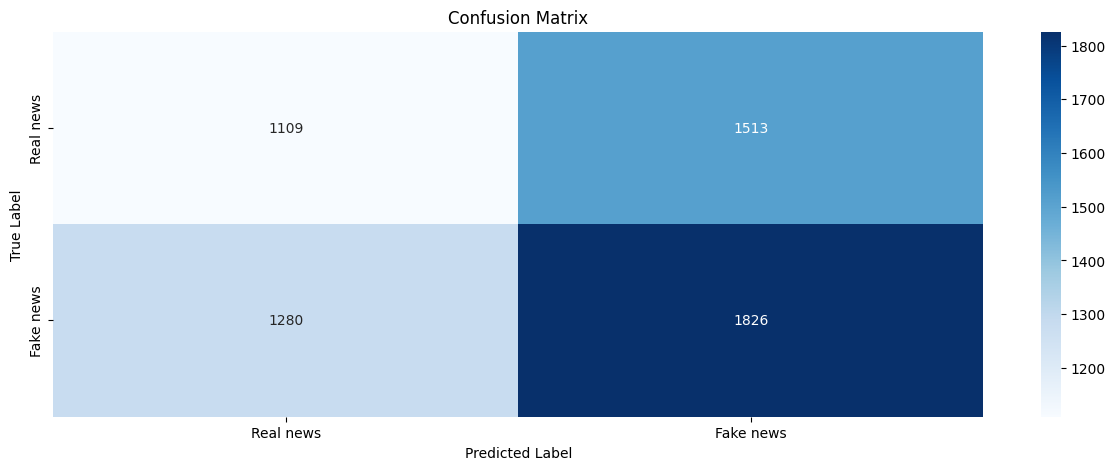

In [ ]:
plt.figure(figsize=(15, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real news', 'Fake news'], yticklabels=['Real news', 'Fake news'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
logits

tensor([[1.6604e-10],
        [1.6385e-09],
        [6.7929e-12],
        [1.6231e-10],
        [1.0000e+00],
        [9.5017e-09],
        [1.0000e+00],
        [1.5814e-11]], device='cuda:0')

# Summary  
An issue in the dataloader caused errors in the predictions, leading to misleading results. However, the notebook is now prepared for experimentation in the next step. Moving forward, we will focus on tuning hyperparameters to identify the best values for optimal performance.